### STREAM mapping approach:
Using a set of cells as reference, construct a pseudotime trajectory. Map other cells of interest into this same space.

For this analysis, NSCLC used as reference and glioma and melanoma mapped onto it.

Here, map glioma and melanoma CD8 T cells to previously generated NSCLC STREAM reference (01_Process_ref_for_STREAM)

In [1]:
## Import modules
import stream as st
import scanpy
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
import os
from pandas.plotting import table 
st.__version__

/Users/jlabelle/opt/anaconda3/envs/env_stream_1.1/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


'1.1'

### Load in data (reference + data to be mapped)

In [2]:
## Load in reference STREAM object (from 01_Process_ref_for_STREAM.ipynb)
analysis_name = "cd8_nsclc"
adata_ref=st.read('./stream_result/stream_result_' + analysis_name + '.pkl')
figure_dir="figures/STREAM/" + analysis_name
if not os.path.isdir(figure_dir):
    os.mkdir(figure_dir)

## Load in data to be mapped: merged cd8 glioma/melanoma object (from STREAM_preprocess.Rmd)
adata_map=scanpy.read_h5ad("analysis/STREAM/cd8_glioma.melanoma.h5ad")
st.set_workdir(adata_map,'./stream_result')
adata_map.var_names_make_unique()
adata_map.X=adata_map.X.toarray()

Working directory is already specified as './stream_result' 
To change working directory, please run set_workdir(adata,workdir=new_directory)
Saving results in: ./stream_result


### Process data

In [10]:
adata_map.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,sample,RNA_snn_res.0.8,seurat_clusters,age_numeric,cellAnnot,NiceSubtype,TumorType,...,branch_lam,branch_dist,S0_pseudotime,S5_pseudotime,S7_pseudotime,S4_pseudotime,S6_pseudotime,S3_pseudotime,S1_pseudotime,S2_pseudotime
MGH207_P4_G06,0,999999.97,1876,MGH207,3,3,37.9,Memory,IDH-G,Glioma,...,0.000000,0.345314,12.504153,6.742202,14.919931,0.000000,18.302842,12.584182,5.188433,1.526596
E_42_P4_B03_E42_CD4.CD8._P3P4P5P6,0,1000000.09,585,E42,7,7,46.8,Stress,IDH-G,Glioma,...,0.000000,0.266827,12.504153,6.742202,14.919931,0.000000,18.302842,12.584182,5.188433,1.526596
E_42_P4_G01_E42_CD4.CD8._P3P4P5P6,0,999999.79,1501,E42,6,6,46.8,Memory,IDH-G,Glioma,...,0.035552,0.379423,12.468601,6.706649,14.884378,0.035552,18.267290,12.548629,5.152880,1.491044
E60_P3_A05_E48.2_CD4.CD8._P3P4,0,999999.94,621,E48.2,6,6,25.9,Predysfunctional,IDH-G,Glioma,...,0.000000,0.240211,12.504153,6.742202,14.919931,0.000000,18.302842,12.584182,5.188433,1.526596
E60_P4_D12_E48.2_CD4.CD8._P3P4,0,999999.86,621,E48.2,6,6,25.9,Memory,IDH-G,Glioma,...,0.000000,0.304458,12.504153,6.742202,14.919931,0.000000,18.302842,12.584182,5.188433,1.526596


In [11]:
## Rename columns so they vary between adata_map and adata_combined
adata_map.var.columns = 'map_'+adata_map.var.columns

## Remove any genes that don't match (different genes in count matrices because from different sources)
sharedGenes=adata_ref.var_names[adata_ref.var_names.isin(adata_map.var_names)]
adata_ref = adata_ref[:, sharedGenes]
adata_map= adata_map[:, sharedGenes]

## Add on tumor type metadata
adata_ref.obs['Tumor_Age']="NSCLC"
adata_map.obs['Tumor_Age']=adata_map.obs['TumorType']

/Users/jlabelle/opt/anaconda3/envs/env_stream_1.1/lib/python3.7/site-packages/ipykernel_launcher.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  # Remove the CWD from sys.path while we load stuff.
/Users/jlabelle/opt/anaconda3/envs/env_stream_1.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  # This is added back by InteractiveShellApp.init_path()


### Merge into single object

In [15]:
adata_combined = st.map_new_data(adata_ref,adata_map)

Top variable genes are being used for mapping ...
method 'mlle' is being used for mapping ...
Visualizing new cells on 2D plane ...
Using the manifold from `plot_visualization_2D()` 


/Users/jlabelle/opt/anaconda3/envs/env_stream_1.1/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [16]:
adata_combined.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,sample,RNA_snn_res.0.8,seurat_clusters,age_numeric,maxGeneset,node,branch_id,...,Tumor_Age,S0_pseudotime,S5_pseudotime,S7_pseudotime,S4_pseudotime,S6_pseudotime,S3_pseudotime,S1_pseudotime,S2_pseudotime,batch
PTC10-0616A-ref,0,998483.262853,2699,P0616A,0,0,74.0,cytotoxic,48,"(48, 29)",...,NSCLC,12.313975,6.552023,14.729752,0.190178,18.112664,12.394003,4.998254,1.336418,ref
PTC1-0616A-ref,0,999171.728957,3115,P0616A,0,0,74.0,cytotoxic,36,"(47, 17)",...,NSCLC,15.890417,17.452138,1.156802,13.763129,6.897608,1.178947,8.574696,12.236533,ref
PTC11-0616A-ref,0,999467.115363,3252,P0616A,4,4,74.0,naive,48,"(48, 29)",...,NSCLC,11.982672,6.220720,14.398449,0.521482,17.781360,12.062700,4.666951,1.005115,ref
PTC12-0616A-ref,0,999344.883214,3582,P0616A,4,4,74.0,naive,30,"(46, 29)",...,NSCLC,14.381442,1.811720,16.797220,4.930482,20.180131,14.461471,7.065722,3.403885,ref
PTC14-0616A-ref,0,999979.300234,3496,P0616A,0,0,74.0,cytotoxic,10,"(49, 17)",...,NSCLC,18.561922,20.123643,6.186201,16.434634,1.868208,3.850452,11.246201,14.908037,ref


### Add on colors for plotting

In [17]:
adata_combined.uns['Tumor_Age_color'] = {'NSCLC':'#e688c4','Melanoma':'#6b8e23', 'Glioma_Ped':'red', 'Glioma_Adult':'blue'}
adata_combined.uns['maxGeneset_color'] = {'cytotoxic':'#adff2f','dysfunctional':'#ff0000', 'naive':'#4a708b', 'predysfunctional':'#ee9572'}

### Plot

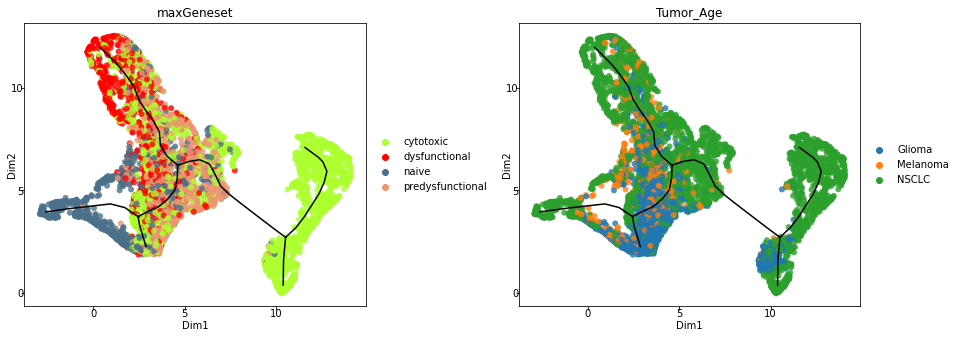

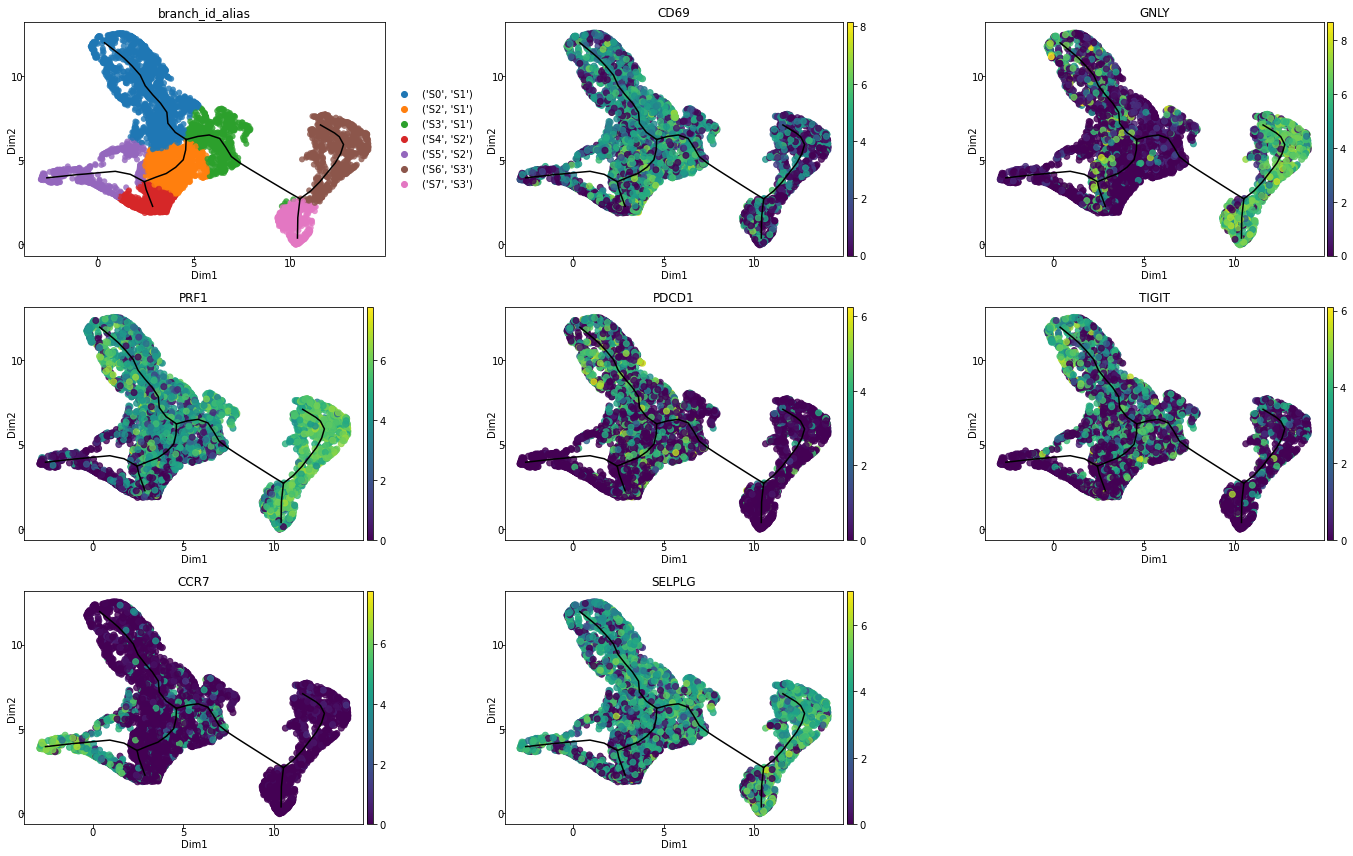

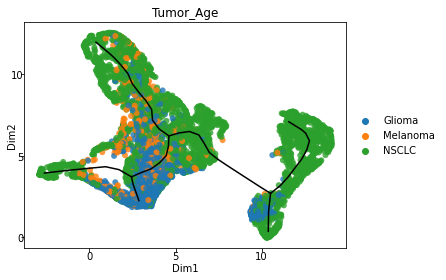

In [18]:
## Plot by max signature and tumor type
st.plot_dimension_reduction(adata_combined,color=[ 'maxGeneset', 'Tumor_Age'],show_graph=True,show_text=False)
figure = plt.gcf()

#figure.set_size_inches(30, 12)
#plt.savefig(figure_dir + "/glioma.melanomaMap_trajectory_flat_maxGeneset_altColor.pdf", dpi=600)

## Plot by genes of interest
st.plot_dimension_reduction(adata_combined,color=['branch_id_alias', 
                                                  "CD69", "GNLY","PRF1", "PDCD1", "TIGIT", "CCR7","SELPLG"],show_graph=True,show_text=False)
#figure = plt.gcf()

#figure.set_size_inches(36, 30)
#plt.savefig(figure_dir + "/glioma.melanomaMap_trajectory_flat.pdf", dpi=600)

## plot just tumor type
st.plot_dimension_reduction(adata_combined,color=[ 'Tumor_Age',],show_graph=True,show_text=False)
#figure = plt.gcf()

#figure.set_size_inches(16, 12)
#plt.savefig(figure_dir + "/glioma.melanomaMap_trajectory_flat_tumorAge.pdf", dpi=600)

### save output

In [ ]:
filename='stream_result_mappedNSCLC.Glioma.Melanoma.pkl'
st.write(adata_combined,file_name=filename)